In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

IMAGES_PATH = Path('./UCMerced_LandUse/Images')

### Calculate sift descriptors for all images

In [2]:
sift = cv2.SIFT_create(nfeatures=0, contrastThreshold=0.039, )


def dataloader(path):
    for image_file in path.rglob('*.tif'):
        img = cv2.imread(str(image_file), 1)
        _, descriptors = sift.detectAndCompute(img, None)
        yield str(image_file), descriptors


def compute_all_descriptors():
    descriptors_list = []
    idx_to_file_path = {}
    with tqdm(total=2100, position=0, leave=True) as program_bar:
        for idx, (file_path, descriptors) in enumerate(dataloader(IMAGES_PATH)):
            descriptors_list.append(descriptors)
            idx_to_file_path[idx] = file_path
            program_bar.update()
    return descriptors_list, idx_to_file_path
    # descriptors: [descriptors_of_img1, descriptors_of_img2,...]
    # idx_to_file_path: {0:'1.tif', 1:'2.tif',...}


descriptors_list, idx_to_file = compute_all_descriptors()
all_descriptors = tuple(des for des in descriptors_list if des is not None)
np.concatenate(all_descriptors).shape

100%|██████████| 2100/2100 [00:43<00:00, 48.35it/s]


(1498637, 128)

### Calculate codebook of BOVW

In [3]:
from sklearn.cluster import MiniBatchKMeans
import time
import pickle

N_CLUSTERS = 15000


def creat_codebook(descriptors_list):
    start = time.time()
    kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=10000, init='random', n_init=1)
    all_descriptors = tuple(des for des in descriptors_list if des is not None)
    kmeans.fit(np.concatenate(all_descriptors))

    print(f'Fitting Kmeans took {int(time.time() - start)}s')
    return kmeans


codebook = creat_codebook(descriptors_list)
with open(f'codebook_{N_CLUSTERS}_{time.time()}.dat', 'wb') as f:
    pickle.dump(codebook, f)

Fitting Kmeans took 786s


#### Load pre-fit codebook

In [4]:
# import pickle
# from sklearn.cluster import MiniBatchKMeans
#
# N_CLUSTERS = 15000
#
# with open('codebook_15000_09-19_17-15.dat', 'rb') as f:
#     codebook = pickle.load(f)


### Create BOVW

In [5]:
from sklearn.preprocessing import normalize

BOVW_NORM = 'l1'


def descriptors_to_bovw(descriptors, codebook):
    _bovw = np.zeros(N_CLUSTERS)
    if descriptors is not None:
        _bovw[codebook.predict(descriptors)] += 1
        _bovw = normalize(_bovw[np.newaxis, :], norm=BOVW_NORM).ravel()
    else:
        _bovw += (1 / N_CLUSTERS)
    return _bovw


def compute_bovws(descriptors_list):
    bovws = []
    with tqdm(total=2100, position=0, leave=True) as program_bar:
        for descriptors in descriptors_list:
            bovw = descriptors_to_bovw(descriptors, codebook)
            bovws.append(bovw)
            program_bar.update()
    return np.stack(bovws)


bovws = compute_bovws(descriptors_list)

100%|██████████| 2100/2100 [01:01<00:00, 34.07it/s]


### Create query tree for KNN Classifier

In [6]:
from sklearn.neighbors import KDTree, BallTree

KNN_METRIC = 'l1'
# KNN_METRIC = 'euclidean'

def create_query_tree(bovws):
    tree = BallTree(bovws, leaf_size=1000, metric=KNN_METRIC)
    return tree


query_tree = create_query_tree(bovws)

### Query demo

In [7]:
def query(img, k_nearest=10):
    _, descriptors = sift.detectAndCompute(img, None)
    bovw = descriptors_to_bovw(descriptors, codebook)
    bovw = bovw[np.newaxis, :]
    # 忽略原图
    _, indexes = query_tree.query(bovw, k_nearest + 1)
    return [idx_to_file[idx] for idx in indexes[0][1:]]


img = cv2.imread('UCMerced_LandUse/Images/agricultural/agricultural00.tif', 1)
print(query(img, 10))

['UCMerced_LandUse\\Images\\agricultural\\agricultural82.tif', 'UCMerced_LandUse\\Images\\agricultural\\agricultural81.tif', 'UCMerced_LandUse\\Images\\agricultural\\agricultural09.tif', 'UCMerced_LandUse\\Images\\agricultural\\agricultural01.tif', 'UCMerced_LandUse\\Images\\agricultural\\agricultural02.tif', 'UCMerced_LandUse\\Images\\agricultural\\agricultural80.tif', 'UCMerced_LandUse\\Images\\agricultural\\agricultural43.tif', 'UCMerced_LandUse\\Images\\agricultural\\agricultural08.tif', 'UCMerced_LandUse\\Images\\agricultural\\agricultural66.tif', 'UCMerced_LandUse\\Images\\agricultural\\agricultural03.tif']


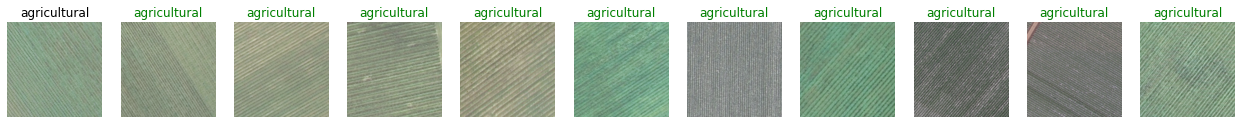

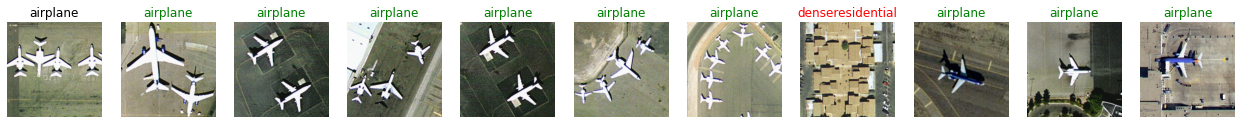

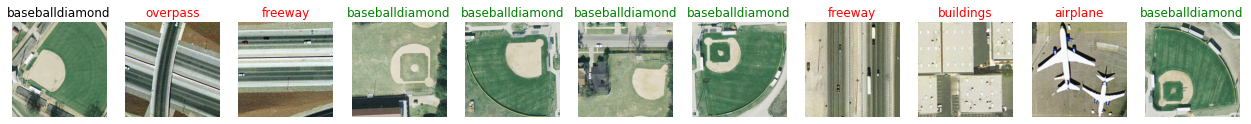

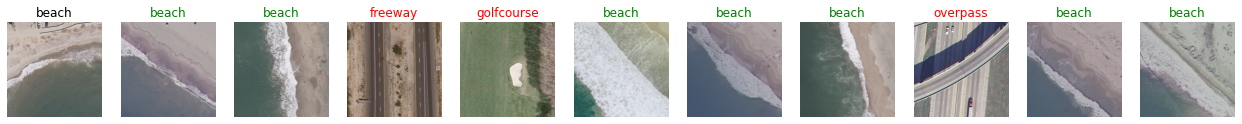

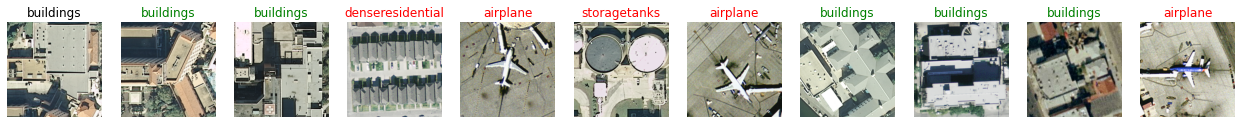

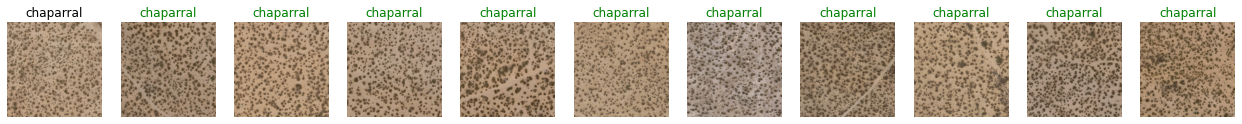

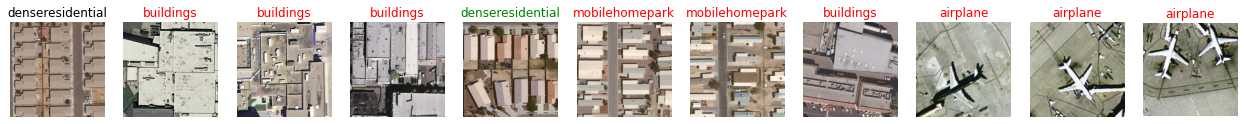

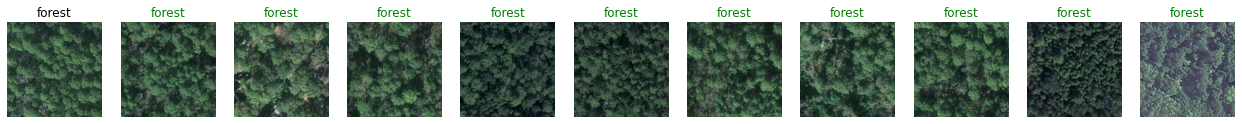

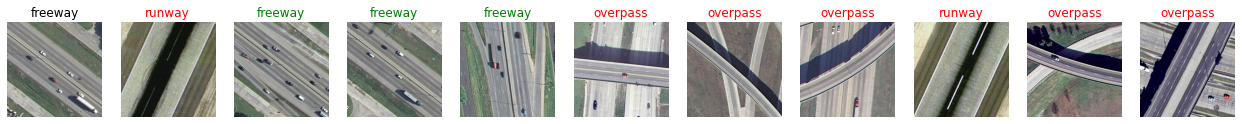

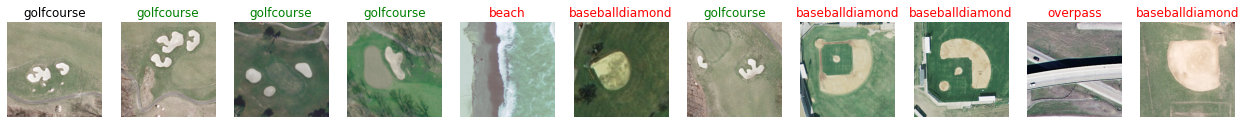

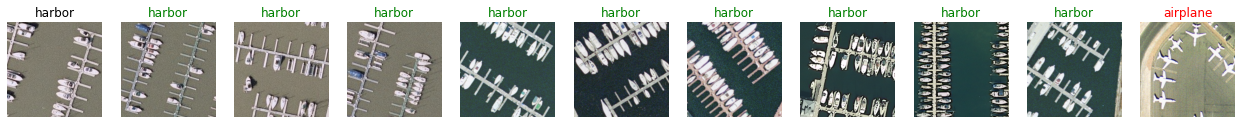

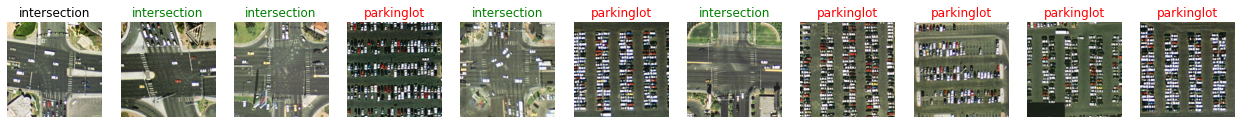

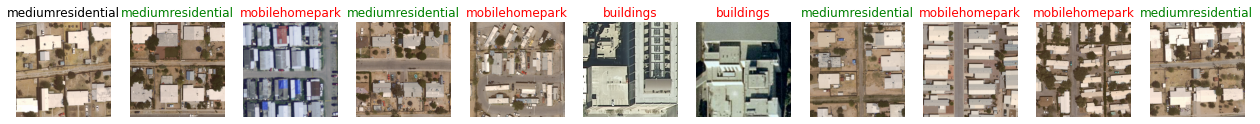

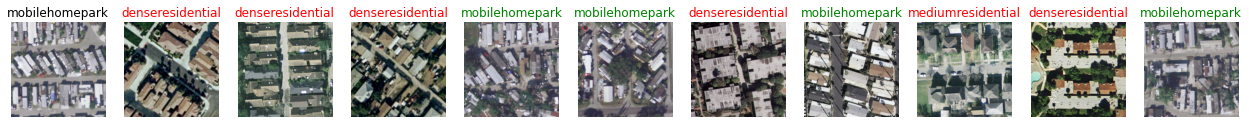

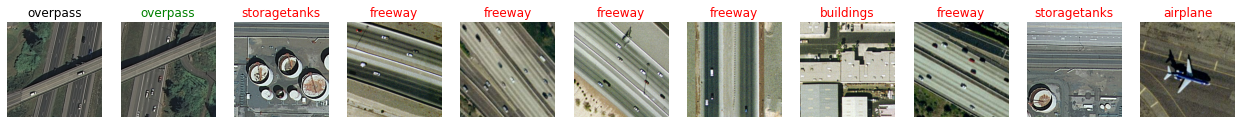

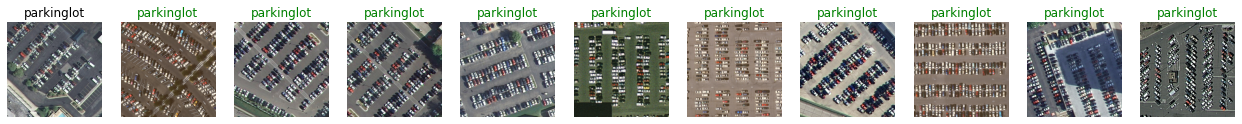

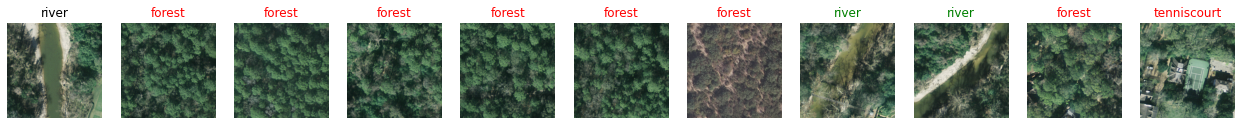

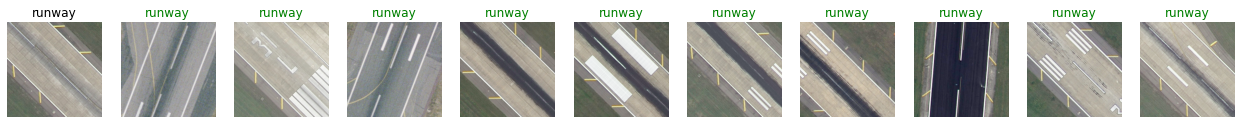

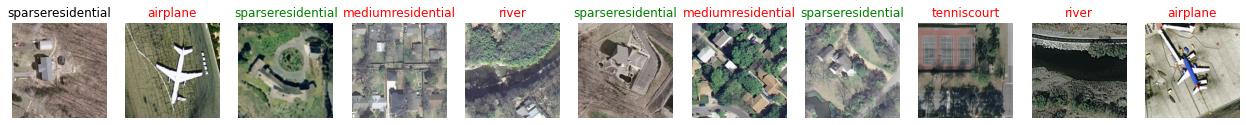

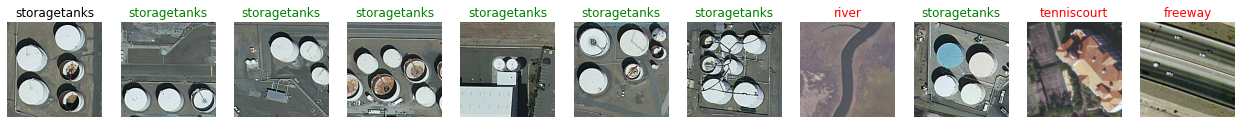

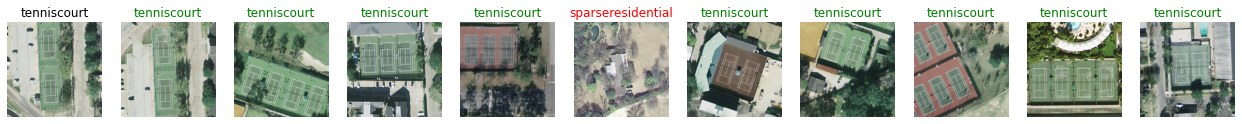

In [8]:
def draw_imgs(img, rows, cols, cnt, title='', color='k'):
    plt.subplot(rows, cols, cnt)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title, color=color)


def show_examples(img_path, k_nearest):
    cols, rows = k_nearest + 1, 1
    plt.figure(figsize=(cols * 2, rows * 2), dpi=72)
    query_img_class = Path(img_path).parts[-2]

    img = cv2.imread(str(img_path), 1)
    draw_imgs(img, rows, cols, 1, query_img_class)
    retrievals = query(img, k_nearest)
    for cnt, img_file in enumerate(retrievals, start=2):
        img = cv2.imread(img_file, 1)
        retrieval_img_class = Path(img_file).parts[-2]
        color = 'g' if retrieval_img_class == query_img_class else 'r'
        draw_imgs(img, rows, cols, cnt, retrieval_img_class, color)
    plt.show()
    plt.close()


for dir in (x for x in IMAGES_PATH.iterdir() if x.is_dir()):
    img_path = list(dir.iterdir())[39]
    show_examples(img_path, 10)

### Calculate the ANMRR metrics of each class

In [9]:
NG = 100
K = 2 * NG


def anmrr(class_name):
    anmrr = 0
    class_path = IMAGES_PATH / class_name
    for img_file in class_path.glob('*.tif'):
        img = cv2.imread(str(img_file), 1)
        cnt, avr = 0, 0
        for idx, query_img in enumerate(query(img, K), start=1):
            if class_name in str(query_img):
                avr += idx
                cnt += 1
        avr += (NG - cnt) * 1.25 * K
        avr /= NG
        nmrr = (avr - 0.5 * (1 + NG)) / (1.25 * K - 0.5 * (1 + NG))
        anmrr += nmrr
    return anmrr / NG


all_class_anmrr = 0

for dir in (x for x in IMAGES_PATH.iterdir() if x.is_dir()):
    class_anmrr = anmrr(dir.name)
    all_class_anmrr += class_anmrr
    print(f'{dir.name:18}:{class_anmrr:.4f}')
print(f'{"AVG":18}:{all_class_anmrr / 21:.4f}')

agricultural      :0.3625
airplane          :0.6502
baseballdiamond   :0.7797
beach             :0.7666
buildings         :0.7141
chaparral         :0.0410
denseresidential  :0.6353
forest            :0.3221
freeway           :0.6371
golfcourse        :0.7710
harbor            :0.2106
intersection      :0.8227
mediumresidential :0.7610
mobilehomepark    :0.5122
overpass          :0.6266
parkinglot        :0.2305
river             :0.7610
runway            :0.4172
sparseresidential :0.8458
storagetanks      :0.8564
tenniscourt       :0.7614
AVG               :0.5945
